In [1]:
Threads.nthreads()

24

In [1]:
using Gridap
import Gridap: ∇
using LinearAlgebra

In [2]:
#Mallado
const global domain = (0,1,0,1)
const global partition = (20,20)
model = CartesianDiscreteModel(domain,partition)
model = simplexify(model)
const global trian = Triangulation(model)
const global degree = 1
const global quad = CellQuadrature(trian,degree)

CellQuadrature()

In [3]:
#Parámetros
const global beta = 0.95
const global nu = 0.99
const global alpha = 0.02

const global t_init = 0.
const global t_end = 2.

const global N_intervalos = 16;

const global n_iter = 5;
const global T = LinRange(t_init, t_end, N_intervalos+1);

In [4]:
#Espacio de funciones

const global V = TestFESpace(
  reffe=:Lagrangian, conformity=:H1, valuetype=Float64,
  model=model, order=1)
  
  
const global W = TrialFESpace(V)

TrialFESpace()

In [5]:
function project(q,trian,quad,order)

  a(u,v) = u*v
  l(v) = v*q
  t_Ω = AffineFETerm(a,l,trian,quad)

  V = TestFESpace(
    reffe=:Lagrangian, valuetype=Float64, order=order,
    triangulation=trian, conformity=:L2)

  U = TrialFESpace(V)
  op = AffineFEOperator(U,V,t_Ω)
  qh = solve(op)
  qh
end

project (generic function with 1 method)

In [6]:
#La formula de cuadratura para la forma bilineal int(u*v), cambia el orden por ser producto de dos polinomios (cada uno de orden "degree")
const global quadL2 = CellQuadrature(trian,2*degree)

CellQuadrature()

In [7]:
x0, y0 = 0.5, 0.5 

S0(x) = 10 -  4*exp(-200*((x[1]-x0)^2 + (x[2]-y0)^2))
I0(x) =  4*exp(-200*((x[1]-x0)^2 + (x[2]-y0)^2))
R0(x) = 0

S0_sol = project(S0,trian,quadL2,1)
I0_sol = project(I0, trian, quadL2, 1)
R0_sol = project(R0, trian, quadL2, 1)

const global U0 = [S0_sol, I0_sol, R0_sol]

3-element Array{Gridap.FESpaces.SingleFieldFEFunction{true},1}:
 SingleFieldFEFunction()
 SingleFieldFEFunction()
 SingleFieldFEFunction()

In [8]:
function EulerMEF(t_init,t_end,n_t,u0)
    S0, I0, R0 = u0
    dt = (t_end - t_init)/n_t
    t = t_init
    
    a_s(S,v) = (1 + dt*beta*I0)*S*v + dt*alpha*∇(v)*∇(S) 
    b_s(v) = v*S0
    
    a_i(I,v) = (1 - dt*beta*S0 + dt*nu)*I*v + dt * alpha*∇(v)*∇(I) 
    b_i(v) = v*I0
    
    a_r(R,v) = R*v + dt * alpha*∇(v)*∇(R)
    b_r(v) = v*(R0 + dt* nu*I0)

    
    for i=1:n_t
        t += dt
        
        t_Ω = AffineFETerm(a_s,b_s,trian,quad)
        op = AffineFEOperator(W,V,t_Ω)
        S_sol = solve(op)
        
        
        t_Ω = AffineFETerm(a_i,b_i,trian,quad)
        op = AffineFEOperator(W,V,t_Ω)
        I_sol = solve(op)
        
        
        t_Ω = AffineFETerm(a_r,b_r,trian,quad)
        op = AffineFEOperator(W,V,t_Ω)
        R_sol = solve(op)

        
        S0 = S_sol
        I0 = I_sol
        R0 = R_sol
        
    end
    return [S0, I0, R0]
end 

EulerMEF (generic function with 1 method)

In [9]:
t_n_f = 70;
const global t_n_c = 20;

@inline F(t1, t0, u0) =  EulerMEF(t0, t1, t_n_f,u0)
@inline G(t1, t0, u0) =  EulerMEF(t0, t1, t_n_c,u0)

G (generic function with 1 method)

In [10]:
function EDP_parareal()
    U = Array{Gridap.Geometry.GenericCellField{true},3}(undef, N_intervalos+1, n_iter+1, 3);
    Fn = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, 3);
    Gn = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, 3);
    G0 = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, 3);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1,1] = 1*S0_sol
    U[1,1,2] = 1*I0_sol
    U[1,1,3] = 1*R0_sol


    for n=1:N_intervalos
        G0[n+1,1], G0[n+1, 2], G0[n+1, 3] = 1*G( T[n+1],T[n],U[n,1,:] )
        U[n+1,1,:] = G0[n+1,:]
    end
    
        
    # 1.b) Inicialización etapas parareal
    @inbounds Threads.@threads for k=1:n_iter
        U[1,k+1,1], U[1,k+1,2], U[1,k+1,3] = 1*S0_sol, 1*I0_sol, 1*R0_sol 
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @inbounds Threads.@threads for n = 1:N_intervalos
            Fn[n,1], Fn[n,2], Fn[n,3]  = 1*F( T[n+1], T[n], U[n,k,:] )
        end
        
        # 2.b) Corrección secuencial
        @inbounds for n = 1:N_intervalos
            Gn[n+1,1], Gn[n+1, 2], Gn[n+1, 3] = 1*G( T[n+1],T[n],U[n,k+1,:] )
            U[n+1, k+1, 1] = Fn[n,1] + Gn[n+1,1] - G0[n+1,1]
            U[n+1, k+1, 2] = Fn[n,2] + Gn[n+1,2] - G0[n+1,2]
            U[n+1, k+1, 3] = Fn[n,3] + Gn[n+1,3] - G0[n+1,3]
        end
        G0 = Gn
    end
    
    return U
    
end

EDP_parareal (generic function with 1 method)

In [11]:
U_SIR = EDP_parareal();

In [12]:
using Plots

In [25]:
suma_S = [ sum(integrate(U_SIR[i,end,1],trian,quad)) for i in 1:N_intervalos+1]
suma_I = [ sum(integrate(U_SIR[i,end,2],trian,quad)) for i in 1:N_intervalos+1]
suma_R = [ sum(integrate(U_SIR[i,end,3],trian,quad)) for i in 1:N_intervalos+1];

In [26]:
vector_sumas = [suma_S,suma_I, suma_R ];
vector_x = 1:N_intervalos;

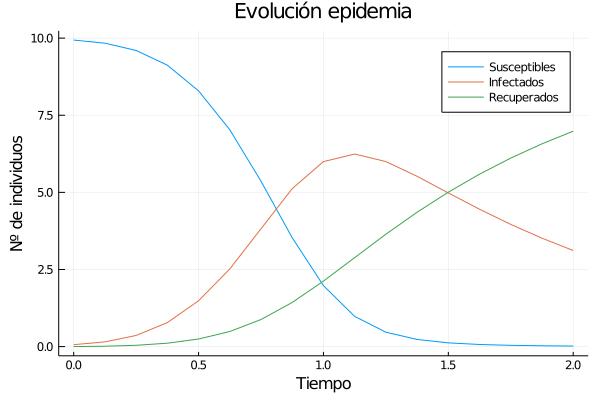

In [29]:
plot(T, vector_sumas, label = ["Susceptibles" "Infectados" "Recuperados"], title="Evolución epidemia", xlabel="Tiempo", ylabel="Nº de individuos")

In [100]:
for i=1:N_intervalos+1
    sol = U_SIR[i,end,1]
    writevtk(trian,"Susceptibles$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end 

In [101]:
for i=1:N_intervalos+1
    sol = U_SIR[i,end,2]
    writevtk(trian,"Infectados$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end 

In [102]:
for i=1:N_intervalos+1
    sol = U_SIR[i,end,3]
    writevtk(trian,"Recuperados$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end 

## TIEMPOS PARAREAL-EULER

In [69]:
function EulerMEF2(t_init,t_end,n_t,t_n_f,u0)
    U = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, 3);
    S0, I0, R0 = u0
    dt = (t_end - t_init)/n_t
    t = t_init
    
    U[1,1] = 1*S0_sol
    U[1,2] = 1*I0_sol
    U[1,3] = 1*R0_sol
    
    a_s(S,v) = (1 + dt*beta*I0)*S*v + dt*alpha*∇(v)*∇(S) 
    b_s(v) = v*S0
    
    a_i(I,v) = (1 - dt*beta*S0 + dt*nu)*I*v + dt * alpha*∇(v)*∇(I) 
    b_i(v) = v*I0
    
    a_r(R,v) = R*v + dt * alpha*∇(v)*∇(R)
    b_r(v) = v*(R0 + dt* nu*I0)

    cont = 2
    
    for i=1:n_t
        t += dt
        
        t_Ω = AffineFETerm(a_s,b_s,trian,quad)
        op = AffineFEOperator(W,V,t_Ω)
        S_sol = solve(op)
        
        
        t_Ω = AffineFETerm(a_i,b_i,trian,quad)
        op = AffineFEOperator(W,V,t_Ω)
        I_sol = solve(op)
        
        
        t_Ω = AffineFETerm(a_r,b_r,trian,quad)
        op = AffineFEOperator(W,V,t_Ω)
        R_sol = solve(op)
        
        if i%t_n_f ==0
            U[cont,1] = 1*S_sol
            U[cont,2] = 1*I_sol
            U[cont,3] = 1*R_sol
            cont +=1
        end
        
        S0 = S_sol
        I0 = I_sol
        R0 = R_sol
        
    end
    return U
end 

EulerMEF2 (generic function with 1 method)

In [70]:
t_n_euler = N_intervalos*t_n_f

1400

In [71]:
tiempos = Array{Float64,2}(undef, 5,2)
for i=1:5
    t_n_f = 200 + (i-1)*100
    t_n_euler = N_intervalos*t_n_f
    t1 = @elapsed EulerMEF2(t_init,t_end,t_n_euler,t_n_f,U0)
    t2 = @elapsed EDP_parareal()
    tiempos[i,1] = t1
    tiempos[i,2] = t2
end

2004006008001000120014001600180020002200240026002800300032003400360038004000300600900120015001800210024002700300033003600390042004500480051005400570060004008001200160020002400280032003600400044004800520056006000640068007200760080005001000150020002500300035004000450050005500600065007000750080008500900095001000060012001800240030003600420048005400600066007200780084009000960010200108001140012000

In [72]:
x_tiempos = LinRange(200, 600, 5);

In [18]:
using Plots

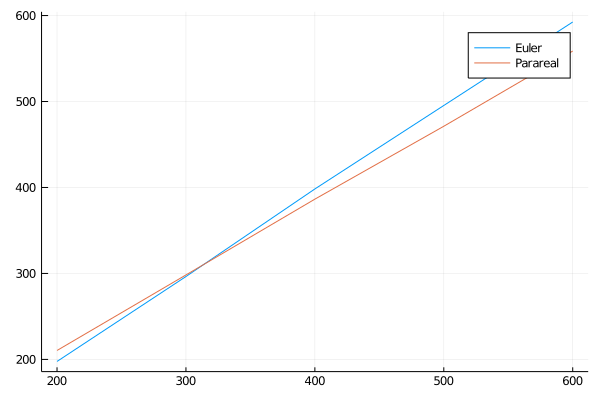

In [73]:
plot(x_tiempos, tiempos, label = ["Euler" "Parareal"])

## ERROR PARAREAL FRENTE EULER

In [45]:
U_EULER = EulerMEF2(t_init,t_end,t_n_euler,t_n_f,U0)

7014021028035042049056063070077084091098010501120

17×3 Array{Gridap.Geometry.GenericCellField{true},2}:
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  Gener

In [46]:
error = U_EULER - U_SIR[:,end,:]

17×3 Array{Gridap.Geometry.GenericCellField{true},2}:
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  GenericCellField()
 GenericCellField()  GenericCellField()  Gener

In [17]:
for i=1:N_intervalos+1
    errS = error[i,1]
    writevtk(trian,"ErrorSuscep$(lpad(i,2,'0'))",cellfields=["error_S" => errS])
end 

for i=1:N_intervalos+1
    errI = error[i,2]
    writevtk(trian,"ErrorInfec$(lpad(i,2,'0'))",cellfields=["error_I" => errI])
end 

for i=1:N_intervalos+1
    errR = error[i,3]
    writevtk(trian,"ErrorRecup$(lpad(i,2,'0'))",cellfields=["error_R" => errR])
end 

In [47]:
L2(w) = w*w

L2 (generic function with 1 method)

In [48]:
error_s = error[:,1];
error_i = error[:,2];
error_r = error[:,3];

In [49]:
error_S_L2 = [sqrt(sum( integrate(L2(i),trian,quad) )) for i in error_s];
error_I_L2 = [sqrt(sum( integrate(L2(i),trian,quad) )) for i in error_i];
error_R_L2 = [sqrt(sum( integrate(L2(i),trian,quad) )) for i in error_r];

In [28]:
using Plots

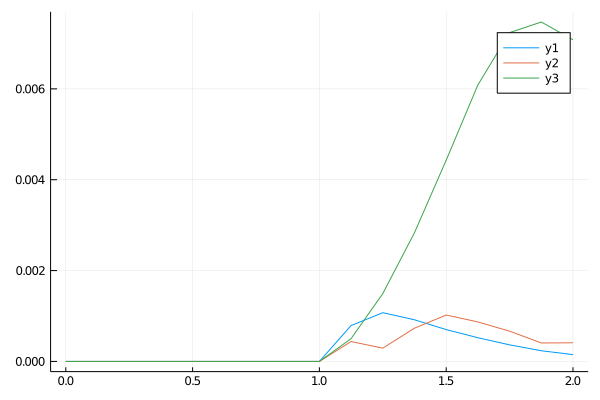

In [50]:
y = [error_S_L2,error_I_L2,error_R_L2]
plot(T, y)

In [51]:
sum(integrate(U_SIR[end,end,1],trian,quad) ) + sum(integrate(U_SIR[end,end,2],trian,quad) ) + sum(integrate(U_SIR[end,end,3],trian,quad) )

10.120744754501853

In [56]:
maximum(error_R_L2)

0.007472087334590479

In [74]:
maximum(error_S_L2)

0.0010726083690141754

In [75]:
maximum(error_I_L2)

0.001021409976429453